# Weather pattern forecasting with LSTM

- **Problem statement:** Forecast the next day's average temperature using the multivariate weather history from Kaggle (`thedevastator/weather-prediction`). The model answers: *given the last 30 days of weather, what should we expect tomorrow's temperature to be?*
- **Significance:** Better short-term forecasts improve planning for agriculture, energy demand, logistics, and safety. A sequence model (LSTM) can leverage temporal patterns and seasonality that simple regressions miss.
- **Plan:** Load the Kaggle dataset via `kagglehub`, explore structure/quality, build an LSTM for regression, evaluate with MAE/RMSE, and note future improvements.


In [1]:
from pathlib import Path
import os
import warnings

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU devices detected:", tf.config.list_physical_devices("GPU"))


/Users/sebastian/ds3001-final/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.16.1
GPU devices detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset
Download the Kaggle dataset with `kagglehub` and inspect the raw file(s). The helper below picks the first CSV found in the download directory so the notebook is resilient to small packaging changes.


In [2]:
# Download and read the dataset
DATASET_SLUG = "thedevastator/weather-prediction"

data_dir = Path(kagglehub.dataset_download(DATASET_SLUG))
csv_files = list(data_dir.rglob("*.csv"))
if not csv_files:
    raise FileNotFoundError("No CSV files found in the downloaded dataset.")

csv_path = csv_files[0]
print(f"Using file: {csv_path}")

df = pd.read_csv(csv_path)
df_raw = df.copy()
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


100%|██████████| 936k/936k [00:00<00:00, 14.2MB/s]

Extracting files...
Using file: /Users/sebastian/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2/weather_prediction_dataset.csv
Shape: (3654, 165)
Columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max', 'BUDAPEST_cloud_cover', 'BUDAPEST_humidity', 'BUDAPEST_pressure', 'BUDAPEST_global_radiation', 'BUDAPEST_precipitation', 'BUDAPEST_sunshine', 'BUDAPEST_temp_mean', 'BUDAPEST_temp_max', 'DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean', 'DE_BILT_temp_min', 'DE_BILT_temp_max', 'DRESDEN_cloud_cover', 'DRESDEN_wind_speed', 'DRESDEN_wind_gust', 'DRESDEN_humidity', 'DRESDEN_global_radiation', 'DRESDEN_precipitation', 'DRESDEN_sunshine', 'DRESDEN_temp_mean', 'DRESDEN_temp_min', 

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


## Quick exploratory data analysis (EDA)
Check structure, missingness, and basic distributions to understand modeling choices and any cleanup required.


In [7]:
# Basic structure and missingness overview
print("Data types and non-null counts:")
info = df.info()

print("\nMissing values (top 10):")
missing = df.isnull().sum().sort_values(ascending=False)
display(missing.head(10))
print("All values present in the dataset")

print("\nSummary stats (numerical):")
display(df.describe().T)


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB

Missing values (top 10):


DATE                         0
MUENCHEN_cloud_cover         0
MUENCHEN_wind_gust           0
MUENCHEN_humidity            0
MUENCHEN_pressure            0
MUENCHEN_global_radiation    0
MUENCHEN_precipitation       0
MUENCHEN_sunshine            0
MUENCHEN_temp_mean           0
MUENCHEN_temp_min            0
dtype: int64

All values present in the dataset

Summary stats (numerical):


,count,mean,std,min,25%,50%,75%,max
DATE,3654.0,2.004568e+07,28742.871733,2.000010e+07,2.002070e+07,2.004567e+07,2.007070e+07,2.010010e+07
MONTH,3654.0,6.520799e+00,3.450083,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
BASEL_cloud_cover,3654.0,5.418446e+00,2.325497,0.000000e+00,4.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00
BASEL_humidity,3654.0,7.451067e-01,0.107788,3.800000e-01,6.700000e-01,7.600000e-01,8.300000e-01,9.800000e-01
BASEL_pressure,3654.0,1.017876e+00,0.007962,9.856000e-01,1.013300e+00,1.017700e+00,1.022700e+00,1.040800e+00
...,...,...,...,...,...,...,...,...
TOURS_global_radiation,3654.0,1.369787e+00,0.926472,5.000000e-02,5.500000e-01,1.235000e+00,2.090000e+00,3.560000e+00
TOURS_precipitation,3654.0,1.861002e-01,0.422151,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e-01,6.200000e+00
TOURS_temp_mean,3654.0,1.220580e+01,6.467155,-6.200000e+00,7.600000e+00,1.230000e+01,1.720000e+01,3.120000e+01
TOURS_temp_min,3654.0,7.860536e+00,5.692256,-1.300000e+01,3.700000e+00,8.300000e+00,1.230000e+01,2.260000e+01


## Target selection and preprocessing
- Detect a date column (if present) to preserve chronological order.
- Auto-pick a temperature-like target; if none found, fall back to the first numeric column.
- Clean missing values (interpolation for numeric, mode for categorical) and one-hot encode categoricals.
- Scale features/target and build sliding windows for the LSTM (30-day lookback).


In [8]:
WINDOW = 30  # days of lookback for each prediction

# Identify date column
potential_date_cols = [c for c in df.columns if "date" in c.lower()]
date_col = potential_date_cols[0] if potential_date_cols else None

# Select a temperature-like target
candidate_keys = ["temp", "temperature", "tavg", "avg_temp", "mean_temp"]
target_col = None
for col in df.columns:
    if any(key in col.lower() for key in candidate_keys):
        target_col = col
        break
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric column available to use as target.")
    target_col = numeric_cols[0]

print(f"Using target column: {target_col}")
if date_col:
    print(f"Date column detected: {date_col}")

# Work on a copy to keep raw data intact
df_work = df.copy()

# Parse and sort by date if present
if date_col:
    df_work[date_col] = pd.to_datetime(df_work[date_col], errors="coerce")
    df_work = df_work.dropna(subset=[date_col])
    df_work = df_work.sort_values(date_col)
else:
    df_work = df_work.sort_index()

# Ensure target is numeric
if not np.issubdtype(df_work[target_col].dtype, np.number):
    df_work[target_col] = pd.to_numeric(df_work[target_col], errors="coerce")

# Handle missing values
numeric_cols = df_work.select_dtypes(include=[np.number]).columns
categorical_cols = df_work.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != target_col and c != date_col]

df_work[numeric_cols] = df_work[numeric_cols].interpolate(limit_direction="both")
df_work[numeric_cols] = df_work[numeric_cols].fillna(df_work[numeric_cols].median())
for col in categorical_cols:
    df_work[col] = df_work[col].fillna(df_work[col].mode().iloc[0])

# Keep a date index for plotting later
if date_col:
    date_index = df_work[date_col].reset_index(drop=True)
else:
    date_index = pd.RangeIndex(len(df_work))

# Prepare model matrix
model_df = df_work.copy()
if date_col and date_col in model_df.columns:
    model_df = model_df.drop(columns=[date_col])

model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)
model_df = model_df.dropna(subset=[target_col])

y = model_df[target_col].values
X = model_df.drop(columns=[target_col]).values

feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()


def create_sequences(features: np.ndarray, target: np.ndarray, window: int):
    Xs, ys = [], []
    for i in range(window, len(features)):
        Xs.append(features[i - window : i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)


X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=WINDOW)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

if date_col:
    date_seq = date_index.iloc[WINDOW:].reset_index(drop=True)
else:
    date_seq = pd.RangeIndex(len(y_seq))
date_test = date_seq[split_idx:]

print(f"Features after encoding: {X.shape[1]}")
print(f"Train sequences: {X_train.shape}, Test sequences: {X_test.shape}")


Using target column: BASEL_temp_mean
Date column detected: DATE
Features after encoding: 163
Train sequences: (2899, 30, 163), Test sequences: (725, 30, 163)


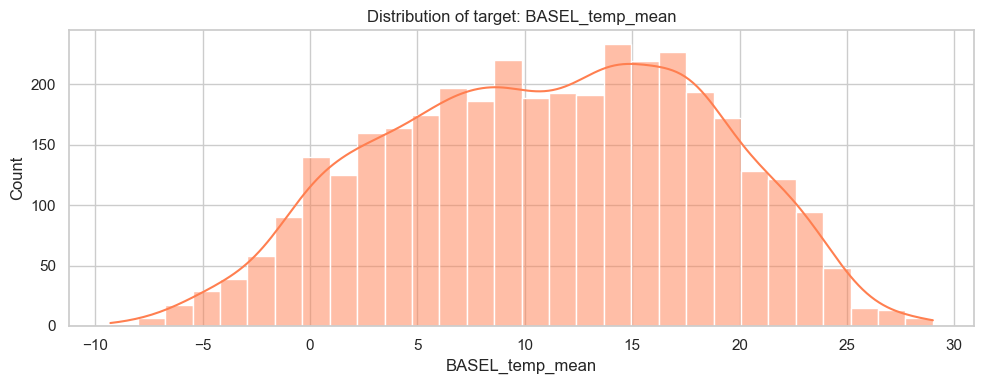

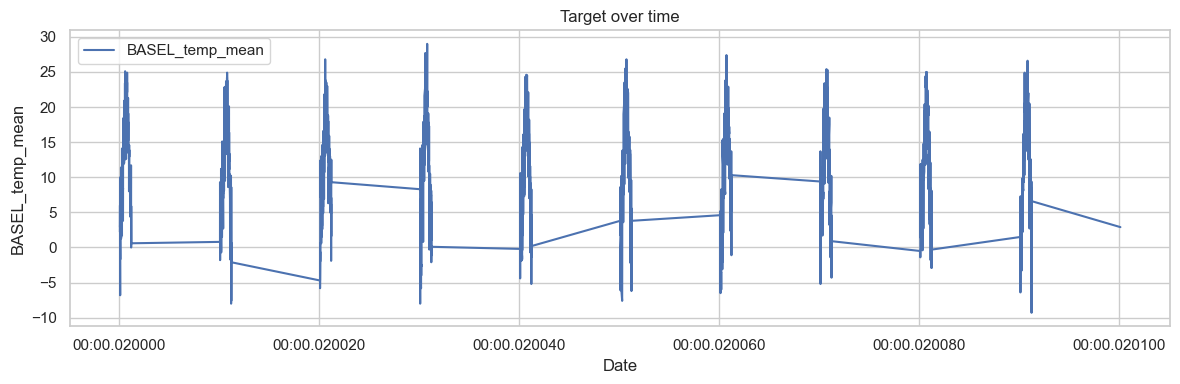

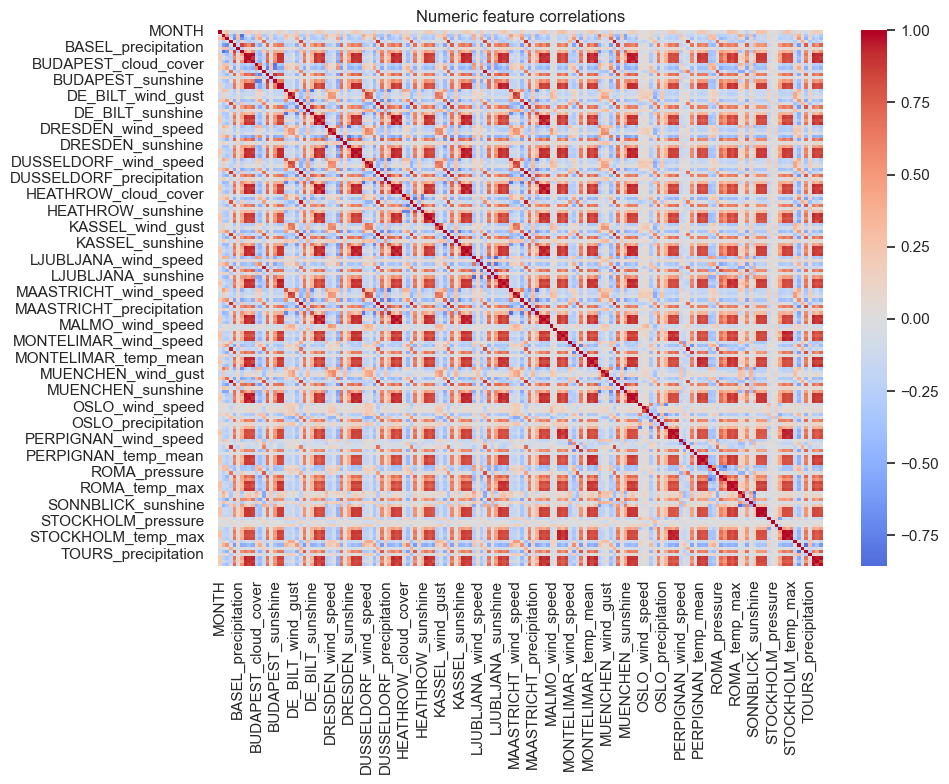

In [5]:
# Visualize target distribution and trend
plt.figure(figsize=(10, 4))
sns.histplot(df_work[target_col], bins=30, kde=True, color="coral")
plt.title(f"Distribution of target: {target_col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
if date_col:
    plt.plot(date_index, df_work[target_col], label=target_col)
    plt.xlabel("Date")
else:
    plt.plot(df_work[target_col].reset_index(drop=True), label=target_col)
    plt.xlabel("Observation index")
plt.ylabel(target_col)
plt.title("Target over time")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = df_work.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Numeric feature correlations")
plt.tight_layout()
plt.show()


## Build and train the LSTM model
We use a two-layer LSTM to capture temporal patterns with early stopping to prevent overfitting. Loss: MSE; metrics: MAE for interpretability.


2025-12-05 16:33:31.137346: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-05 16:33:31.137389: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-05 16:33:31.137409: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-05 16:33:31.137468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 16:33:31.137484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-12-05 16:33:32.108784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.1940 - mae: 0.3394 - val_loss: 0.1312 - val_mae: 0.2904
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0905 - mae: 0.2376 - val_loss: 0.1196 - val_mae: 0.2797
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0727 - mae: 0.2134 - val_loss: 0.1141 - val_mae: 0.2737
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0618 - mae: 0.1952 - val_loss: 0.0989 - val_mae: 0.2536
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0541 - mae: 0.1834 - val_loss: 0.0985 - val_mae: 0.2531
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0493 - mae: 0.1717 - val_loss: 0.0938 - val_mae: 0.2471
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0479 - mae: 0.1707 - val_loss: 0.0957 - val_mae: 0.2499
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0433 - mae: 0.1628 - val_loss: 0.0977 - val_mae: 0.2526
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0390 - mae: 0.

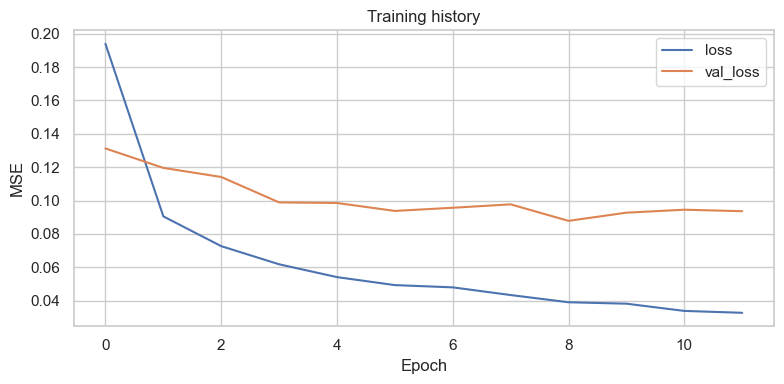

In [9]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mae"])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8, 4))
plt.plot(history_df["loss"], label="loss")
plt.plot(history_df["val_loss"], label="val_loss")
plt.title("Training history")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()


## Evaluate and visualize predictions
Compute MAE/RMSE on the test window and plot actual vs predicted temperatures.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'MAE': 1.6206813201801529, 'RMSE': 2.0310914483228895, 'R2': 0.9234232375176994}


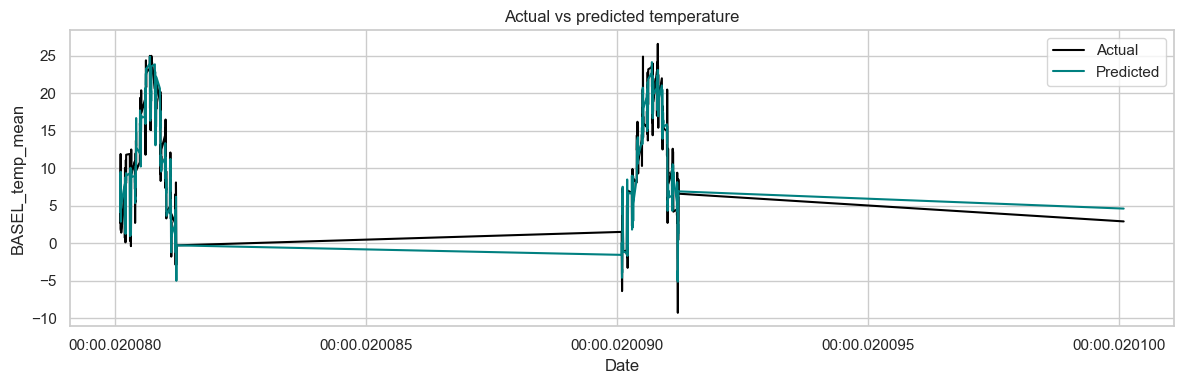

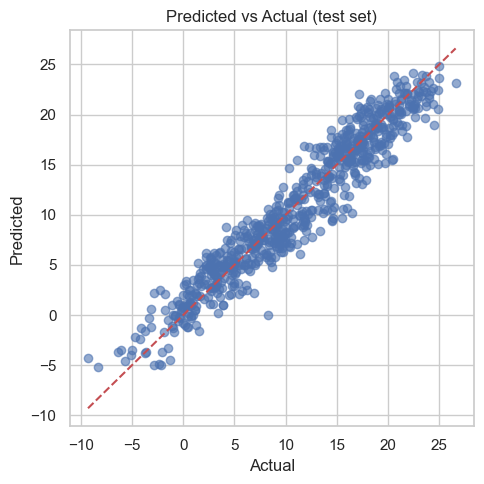

In [11]:
# Predict on the hold-out set and invert scaling
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled).flatten()
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_true, y_pred)
try:
    rmse = mean_squared_error(y_true, y_pred, squared=False)
except TypeError:  # compatibility with older scikit-learn
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print({"MAE": mae, "RMSE": rmse, "R2": r2})

plt.figure(figsize=(12, 4))
plt.plot(date_test, y_true, label="Actual", color="black")
plt.plot(date_test, y_pred, label="Predicted", color="teal")
plt.title("Actual vs predicted temperature")
plt.xlabel("Date" if date_col else "Sequence index")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (test set)")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.tight_layout()
plt.show()


## Opportunities for improvement
- Tune lookback window, hidden sizes, and learning rate; consider 1D CNN + LSTM hybrids.
- Try exogenous features (holiday flags, lagged precipitation) and seasonality decompositions.
- Perform rolling-origin evaluation instead of a single train/test split for more robust error estimates.
- Add probabilistic forecasts (MC dropout or quantile loss) to capture uncertainty.
- If dataset grows, consider `tf.data` pipelines and mixed precision (`tf.keras.mixed_precision.set_global_policy('mixed_float16')`) to speed training on Apple Silicon.
